In [212]:
!ls

archive.zip  fruit_vegetable_cls.ipynb	test  train  validation


数据集地址：[kaggle 果蔬分类数据集](https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition)

百度网盘：链接：https://pan.baidu.com/s/1q-fS2M97er1-769Ol-htSg 提取码：t0ww

In [213]:
# 导入必要的包
import os
import torch
import timm
from torchvision import transforms
import numpy as np
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [214]:
# 设置随机种子，确保结果可以复现
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [210]:
# 设置文件路径
train_path = './train/'
val_path = './validation/'
test_path = './test/'

# 设置超参数
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 32

# num_workers wins用户只能指定为0
num_workers = 4
lr = 3e-4
epochs = 10

# 输出类别
categories = os.listdir(train_path)
print(f"Categories: {len(categories)}")

Categories: 36


In [216]:
# 使用imgaug对图像进行数据增强
import imageio
import imgaug as ia
from imgaug import augmenters as iaa

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img).transpose(2,1,0)

# linux用户num_worker≠0时使用
def worker_init_fn(worker_id):
    imgaug.seed(np.random.get_state()[1][0] + worker_id)

tfs = ImgAugTransform()

torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


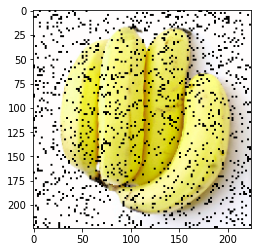

In [220]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
# 自定义数据集
train_dataset = ImageFolder(train_path,transform=tfs)
val_dataset = ImageFolder(val_path,transform=tfs)
test_dataset = ImageFolder(test_path,transform=tfs)

train_loader = DataLoader(train_dataset,batch_size=batch_size,worker_init_fn=worker_init_fn,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,worker_init_fn=worker_init_fn,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=batch_size,worker_init_fn=worker_init_fn,shuffle=False)

# 可视化图片
images, labels = next(iter(train_loader))
print(images.shape)
print(type(images))
print(images[1].shape)
plt.imshow(images[0].permute(1,2,0))
plt.show()

In [222]:
import timm
# 使用timm使用预训练模型
model = timm.create_model("resnet18",num_classes=36,pretrained=True).to(device)

In [223]:
avail_pretrained_models = timm.list_models(pretrained=True)
len(avail_pretrained_models)

592

In [227]:
# 使用通配符查找resnet系列
all_resnent_models = timm.list_models("*resnet*")
all_resnent_models

['cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'eca_resnet33ts',
 'ecaresnet26t',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet50t',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnet200d',
 'ecaresnet269d',
 'ecaresnetlight',
 'ens_adv_inception_resnet_v2',
 'gcresnet33ts',
 'gcresnet50t',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resnet101_v1b',
 'gluon_resnet101_v1c',
 'gluon_resnet101_v1d',
 'gluon_resnet101_v1s',
 'gluon_resnet152_v1b',
 'gluon_resnet152_v1c',
 'gluon_resnet152_v1d',
 'gluon_resnet152_v1s',
 'inception_resnet_v2',
 'lambda_resnet26rpt_256',
 'lambda_resnet26t',
 'lambda_resnet50ts',
 'legacy_seresnet18',
 'legacy_seresnet34',
 'legacy_seresnet50',
 'legacy_seresnet101',
 'legacy_seresnet152',
 'nf_ecaresnet26',
 'nf_ecaresnet50',
 'nf_ecaresnet101',
 'nf_resnet26',
 'nf_resnet50',
 'nf_resnet101',
 'nf_seresnet26',
 'nf_seresnet50',
 'nf_seresnet1

In [136]:
# 查看模型默认的cfg
model.default_cfg

{'url': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet18'}

In [190]:
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# 设置优化器和损失函数
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=3e-4, betas=[0.9, 0.99], eps=1e-08, weight_decay=0.0)
scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0)
# 模型训练
def train(epoch,model,train_loader):
    model.train()
    train_loss = 0
    for image, target in tqdm(train_loader):
        image = image.float()
        image = image.to(device)
        target = target.to(device)
        predict = model(image)
        loss = criterion(predict, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * image.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [225]:
# 测试集验证
def val(epoch,model,val_dataloader):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in tqdm(val_dataloader):
            data, label = data.float().to(device), label.to(device)
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_dataloader)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels == pred_labels) / len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [226]:
# 验证集验证
def test(epoch,model,test_dataloader):
    model.eval()
    test_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in tqdm(test_dataloader):
            data, label = data.float().to(device), label.to(device)
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels == pred_labels) / len(pred_labels)
    print('Epoch: {} \tTest  Accuracy: {:6f}'.format(epoch, acc))

以下仅展示训练和测试验证的结果。保存参数可以根据实际需求进行保存

In [211]:
for epoch in range(epochs):
    train(1,model,train_loader)
    val(1,model,val_loader)
    test(1,model,test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:50<00:00,  1.74s/it]


Epoch: 1 	Training Loss: 1.017386


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.49s/it]


Epoch: 1 	Validation Loss: 27.227383, Accuracy: 0.746439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch: 1 	Test  Accuracy: 0.738162


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:44<00:00,  1.68s/it]


Epoch: 1 	Training Loss: 0.844879


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:28<00:00,  2.57s/it]


Epoch: 1 	Validation Loss: 10.465725, Accuracy: 0.897436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.20s/it]


Epoch: 1 	Test  Accuracy: 0.905292


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:44<00:00,  1.68s/it]


Epoch: 1 	Training Loss: 0.582476


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:22<00:00,  2.03s/it]


Epoch: 1 	Validation Loss: 15.013344, Accuracy: 0.871795


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.06s/it]


Epoch: 1 	Test  Accuracy: 0.844011


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:44<00:00,  1.67s/it]


Epoch: 1 	Training Loss: 0.632940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.17s/it]


Epoch: 1 	Validation Loss: 7.386183, Accuracy: 0.928775


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch: 1 	Test  Accuracy: 0.908078


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:39<00:00,  1.63s/it]


Epoch: 1 	Training Loss: 0.415200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:26<00:00,  2.40s/it]


Epoch: 1 	Validation Loss: 13.273417, Accuracy: 0.857550


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:26<00:00,  2.18s/it]


Epoch: 1 	Test  Accuracy: 0.874652


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:40<00:00,  1.64s/it]


Epoch: 1 	Training Loss: 0.544968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.20s/it]


Epoch: 1 	Validation Loss: 6.059515, Accuracy: 0.940171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch: 1 	Test  Accuracy: 0.933148


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:47<00:00,  1.71s/it]


Epoch: 1 	Training Loss: 0.350375


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:22<00:00,  2.02s/it]


Epoch: 1 	Validation Loss: 11.914146, Accuracy: 0.897436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch: 1 	Test  Accuracy: 0.899721


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:37<00:00,  1.61s/it]


Epoch: 1 	Training Loss: 0.459682


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.23s/it]


Epoch: 1 	Validation Loss: 6.115790, Accuracy: 0.943020


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:25<00:00,  2.09s/it]


Epoch: 1 	Test  Accuracy: 0.935933


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:31<00:00,  1.55s/it]


Epoch: 1 	Training Loss: 0.261108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.23s/it]


Epoch: 1 	Validation Loss: 7.643102, Accuracy: 0.923077


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:24<00:00,  2.06s/it]


Epoch: 1 	Test  Accuracy: 0.927577


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:40<00:00,  1.64s/it]


Epoch: 1 	Training Loss: 0.404539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.27s/it]


Epoch: 1 	Validation Loss: 7.167813, Accuracy: 0.934473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:27<00:00,  2.28s/it]

Epoch: 1 	Test  Accuracy: 0.941504
